# Parameter Estimation of BioModels

## Visualization of BMSS Inducible Promoter

The input file is comma separated. The columns are as shown:

|Time(min)|0.1250%|0.0625%|...|0.1250%std|0.0625%std|...|
|---|---|---|---|---|---|---|
|0|27.59477097|22.55970886|...|2.962316885|5.863280261|...|

The input file includes characterization data *normalized by growth data*, and respective standard deviations.

**The difference between BMSS and the Bayesian models**

BMSS model fits to the temporal curve, while the Bayesian curve fits to the dose-response curve with the concentration of inducer as "input" and the "relative activity" as the "output". 

We will find the linear region (dynamic region) of each curve and obtain the *relative activity*.

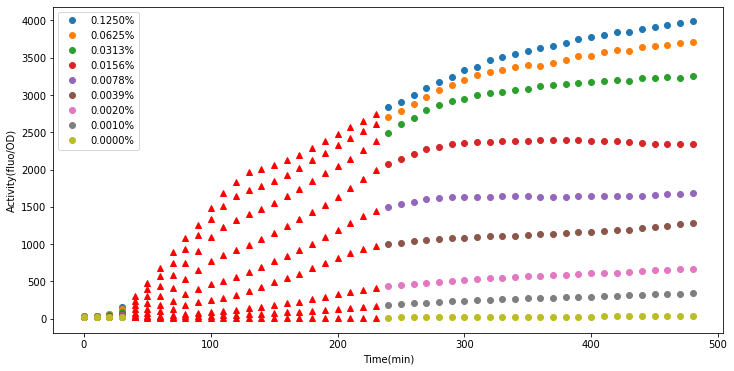

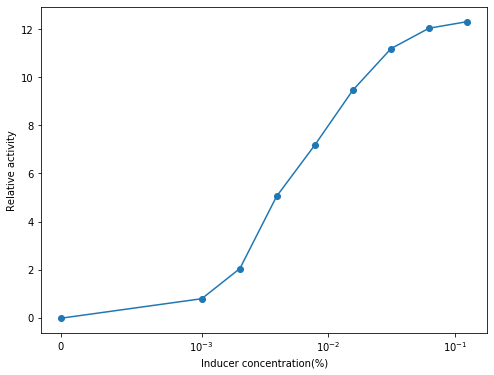

In [2]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np

# Read input file
PATH = 'data/Inducible_pBADAra_rbspBb_MG.csv'
fi = open(PATH, 'r')
rawInput = []
with fi :
    for line in fi :
        splitLine = line.strip().split(',')
        rawInput.append(splitLine)
rawInput = [ [ row[i] for row in rawInput ] for i in range(len(rawInput[0])) ]    # transpose
tp = [int(x) for x in rawInput[0][1:]]
act = [[float(x) for x in row[1:]] for row in rawInput[1:(len(rawInput)+1)//2]]
std = [[float(x) for x in row[1:]] for row in rawInput[(len(rawInput)+1)//2:]]
conc = [row[0] for row in rawInput[1:(len(rawInput)+1)//2]]

# Truncation
DLIM = (0.1, 0.5)
myRange = [int(len(tp)*DLIM[0]), int(len(tp)*DLIM[1])]

# Rendering
fig, ax = plt.subplots(figsize=(12, 6))
for act_i, std_i, conc_i in zip(act, std, conc) :
    ax.plot(tp[:myRange[0]] + tp[myRange[1]:],
            act_i[:myRange[0]] + act_i[myRange[1]:], 'o', label=conc_i)
    ax.plot(tp[myRange[0]:myRange[1]], act_i[myRange[0]:myRange[1]], '^r')
    #ax.errorbar(tp, act_i, std_i, fmt='none', ecolor='k')
ax.legend()
ax.set_xlabel('Time(min)'); ax.set_ylabel('Activity(fluo/OD)')

# Continue Truncation
A = [[t, 1] for t in tp[myRange[0]:myRange[1]]]
ssAct = [np.linalg.lstsq(A, row[myRange[0]:myRange[1]], rcond=None)[0][0] for row in act]
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot([float(x[:-1]) for x in conc], ssAct, 'o-')
ax.set_xscale('symlog', linthreshx=1e-3)
ax.set_xlabel('Inducer concentration(%)'); _ = ax.set_ylabel('Relative activity')

In [3]:
print([float(x[:-1]) for x in conc])
print(ssAct)

[0.125, 0.0625, 0.0313, 0.0156, 0.0078, 0.0039, 0.002, 0.001, 0.0]
[12.311223552518806, 12.037865301112788, 11.189426750323312, 9.456048226624064, 7.1701918251594, 5.044574212420302, 2.0449053042691734, 0.7903555097488724, -0.019301454486466134]


## Estimation of parameters

The target function is to minimize the sum of square error (SSE). It is equivalent to Bayesian estimation, if the likelihood function is Gaussion distribution, i.e. $N(y_i, \mu)$ and the variance is set to a constant.

In the Bayesian estimation paper, the likelihood function includes a noise funciton g(x), which depends on $x_i$, but now we just set the noise to a constant.

Estimating parameter from Bayes formula by maximizing the posterior is called MAP. If the priori probability, $P(\theta)$ obeys uniform distribution, then MAP is the same as Maximum Likelihood Estimation (MLE). In this case, it is just minimizing the SSE.

We select the model: activation with leaky expression, i.e.

$P = \frac{a\cdot[A]^n+b\cdot K^n}{[A]^n+K^n}$

In [116]:
# define the target function (SSE)
nConc = [float(x[:-1]) for x in conc]

def hill(A, x) :
    a, b, K, n = x
    return (a * A ** n + b * K ** n) / (A ** n + K ** n)

def sse(x) :
    se = []
    for conc_i, act_i in zip(nConc, ssAct) :
        y_i = hill(conc_i, x)
        se.append((y_i - act_i) ** 2)
    return sum(se)

x_0 = [10, 0.1, 5e-3, 2]
print(sse(x_0))

13.92117293694845


theta: [ 1.25479410e+01 -1.98535618e-01  5.93176818e-03  1.27539696e+00] SSE: 0.5197444373516091 
Running time: 0.03255152702331543 s


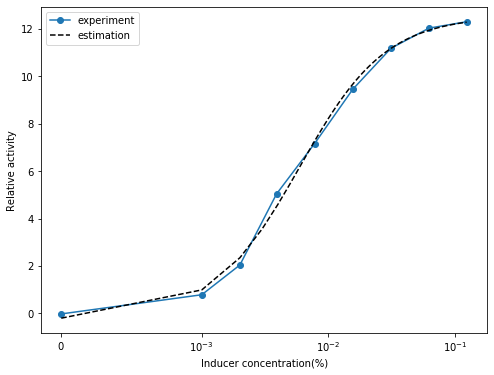

In [130]:
from scipy.optimize import minimize
import time

# Paramteter estimation
startTime = time.time()
res = minimize(sse, x_0, method='nelder-mead')
endTime = time.time()
print('theta:', res.x, 'SSE:', res.fun, '\nRunning time:', endTime - startTime, 's')

# Rendering
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(nConc, ssAct, 'o-', label='experiment')
xNew = np.arange(0, 0.125, 0.001)
ax.plot(xNew, [hill(x, res.x) for x in xNew], '--k', label='estimation')
ax.set_xscale('symlog', linthreshx=1e-3)
ax.legend()
ax.set_xlabel('Inducer concentration(%)'); _ = ax.set_ylabel('Relative activity')